In [ ]:
# #解压数据集
# !unzip data/data79392/EG1800.zip -d mydata
# !unzip data/data79392/Supervisely_face.zip -d mydata

In [ ]:
# #将数据集标注txt文件移动到mydata中对应数据集路径下
# !cp work/eg1800_train.txt mydata/EG1800
# !cp work/eg1800_test.txt mydata/EG1800
# !cp work/supervisely_face_train_easy.txt mydata/Supervisely_face
# !cp work/supervisely_face_test_easy.txt mydata/Supervisely_face

## EG1800

In [ ]:
#需要导入的库
import numpy as np
import paddle
import paddle.nn as nn
import paddle.nn.functional as F
import glob
import os
import matplotlib.pyplot as plt
import cv2
import shutil
import random
import pandas as pd
import math
from easydict import EasyDict as edict
from paddle.static import InputSpec
from visualdl import LogWriter
from sklearn import svm
from sklearn.metrics import roc_curve, auc  ###计算roc和auc
from sklearn.preprocessing import OneHotEncoder
from itertools import cycle
from paddle.io import Dataset
from paddle.fluid.dygraph.base import to_variable
from work.models.PortraitNet import MobileNetV2

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/layers/utils.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def convert_to_list(value, n, name, dtype=np.int):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matp

In [ ]:
exp_args = edict()
exp_args.istrain = True # set the mode 
exp_args.task = "seg" # only support 'seg' now
exp_args.datasetlist = ['EG1800']
exp_args.data_root = "/home/aistudio/mydata/"
exp_args.file_root = "/home/aistudio/mydata/EG1800/"
# exp_args.datasetlist = ['supervisely_face_easy']
# exp_args.data_root = "/home/aistudio/mydata/"
# exp_args.file_root = "/home/aistudio/mydata/Supervisely_face/"

# the height of input images, default=224
exp_args.input_height = 352
# the width of input images, default=224
exp_args.input_width = 352

# if exp_args.video=True, add prior channel for input images, default=False
exp_args.video = False
# the probability to set empty prior channel, default=0.5
exp_args.prior_prob = 0.5

# whether to add boundary auxiliary loss, default=False
exp_args.addEdge = True
# the weight of boundary auxiliary loss, default=0.1
exp_args.edgeRatio = 0.1
# whether to add consistency constraint loss, default=False
exp_args.stability = True
# whether to use KL loss in consistency constraint loss, default=True
exp_args.use_kl = True
# temperature in consistency constraint loss, default=1
exp_args.temperature = 1 
# the weight of consistency constraint loss, default=2
exp_args.alpha = 2

# input normalization parameters
exp_args.padding_color = 128
exp_args.img_scale = 1
# BGR order, image mean, default=[103.94, 116.78, 123.68]
exp_args.img_mean = [103.94, 116.78, 123.68]
# BGR order, image val, default=[1/0.017, 1/0.017, 1/0.017]
exp_args.img_val = [0.017, 0.017, 0.017]

# whether to use pretian model to init portraitnet
exp_args.init = False
# whether to continue training
exp_args.resume = False

# if exp_args.useUpsample==True, use nn.Upsample in decoder, else use nn.ConvTranspose2d
exp_args.useUpsample = False
# if exp_args.useDeconvGroup==True, set groups=input_channel in nn.ConvTranspose2d
exp_args.useDeconvGroup = False 

# set training dataset
exp_args.istrain = True

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data
2023-11-15 18:15:25,559 - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/home/aistudio/work
=============train dataset=============
(3, 352, 352)
(3, 352, 352)
(352, 352)
(352, 352)


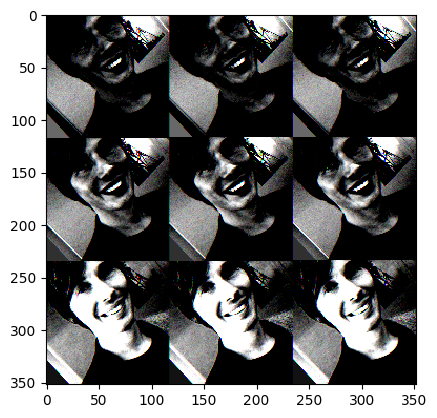

2023-11-15 18:15:25,855 - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


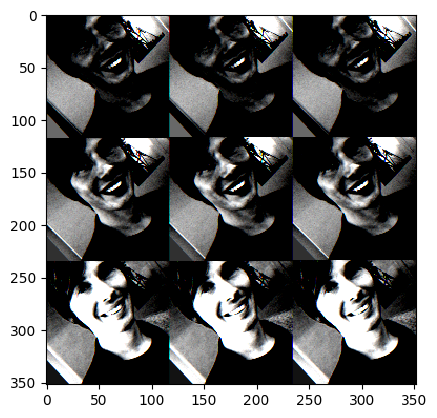

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:425: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_min = np.asscalar(a_min.astype(scaled_dtype))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:426: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_max = np.asscalar(a_max.astype(scaled_dtype))


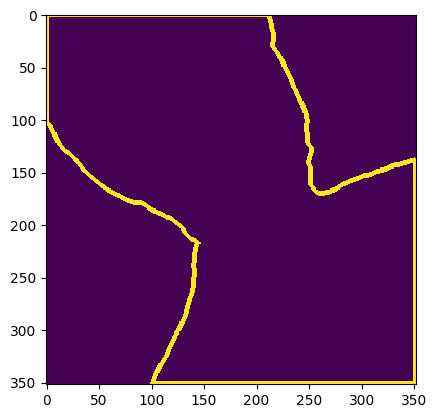

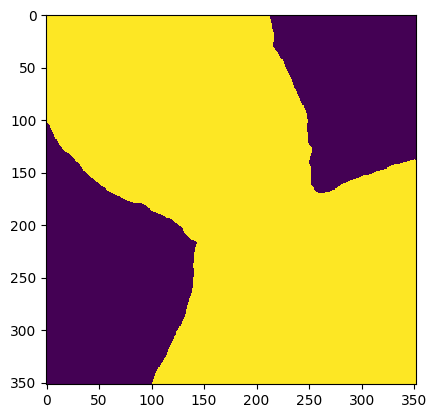

In [ ]:

%cd work/
from data import MyDataset 
train_dataset = MyDataset(exp_args)
# val_dataset = MyDataset(is_model = "")
num = 0
print('=============train dataset=============')
for input_ori, input, output_edge, output_mask in train_dataset:
    #num += 1
    print(input_ori.shape)
    print(input.shape)
    print(output_edge.shape)
    print(output_mask.shape)
    #可视化
    input_ori = input_ori.reshape([input_ori.shape[1],input_ori.shape[2],input_ori.shape[0]])
    plt.imshow(input_ori)
    plt.show()

    input = input.reshape([input.shape[1],input.shape[2],input.shape[0]])
    plt.imshow(input)
    plt.show()

    plt.imshow(output_edge)
    plt.show()

    plt.imshow(output_mask)
    plt.show()

    break

In [ ]:

mymodel = MobileNetV2(n_class=2, 
                            useUpsample=exp_args.useUpsample, 
                            useDeconvGroup=exp_args.useDeconvGroup, 
                            addEdge=exp_args.addEdge, 
                            channelRatio=1.0, 
                            minChannel=16, 
                            video=exp_args.video)


W1115 18:15:39.720412   134 device_context.cc:362] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 12.0, Runtime API Version: 10.1
W1115 18:15:39.725827   134 device_context.cc:372] device: 0, cuDNN Version: 7.6.


In [ ]:

writer = LogWriter("./log_eg1800")

In [ ]:

def calcIOU(img, mask):
    sum1 = img + mask
    sum1[sum1>0] = 1
    sum2 = img + mask
    sum2[sum2<2] = 0
    sum2[sum2>=2] = 1
    if np.sum(sum1) == 0:
        return 1
    else:
        return 1.0*np.sum(sum2)/np.sum(sum1)
def loss_KL(student_outputs, teacher_outputs, T):
    """
    Code referenced from: 
    https://github.com/peterliht/knowledge-distillation-pytorch/blob/master/model/net.py
    
    Compute the knowledge-distillation (KD) loss given outputs, labels.
    "Hyperparameters": temperature and alpha
    NOTE: the KL Divergence for PyTorch comparing the softmaxs of teacher
    and student expects the input tensor to be log probabilities! See Issue #2
    """
    KD_loss = paddle.nn.KLDivLoss()(F.log_softmax(student_outputs/T, axis=1), 
                             F.softmax(teacher_outputs/T, axis=1)) * T * T
    return KD_loss
#Focalloss
def loss_Focalloss(pred,label,gamma = 2.0):
    N,C,H,W = pred.shape[0],pred.shape[1],pred.shape[2],pred.shape[3]
    pred = pred.reshape([N,C,-1])# N,C,H,W => N,C,H*W
    pred = pred.transpose((0,2,1))# N,C,H*W => N,H*W,C
    pred = pred.reshape([-1,C])# N,H*W,C => N*H*W,C
    label = label.reshape([-1,1])#N,H,W => N*H*W,1
    
    label = paddle.squeeze(label,axis=1)#去除多余维度
    label = paddle.nn.functional.one_hot(label, num_classes=2)
    label = paddle.to_tensor(label,dtype="float32")

    one = paddle.to_tensor([1.], dtype='float32')
    fg_label = paddle.greater_equal(label, one)
    fg_num = paddle.sum(paddle.cast(fg_label, dtype='float32'))
    loss_focal = paddle.nn.functional.sigmoid_focal_loss(pred,label,normalizer=fg_num)
    # pt = paddle.nn.functional.softmax(pred)#带入分类器
    # #a = paddle.to_tensor(1,dtype="int64")
    # label_one_hot = paddle.nn.functional.one_hot(label, num_classes=2)
    # pt = paddle.multiply(pt,label_one_hot)
    # #pt = pt.gather(a,label)#将是1的标签提取出来
    # # min_pro = paddle.to_tensor(0.1,dtype="float64")
    # # pt = paddle.maximum(pt,min_pro)#当预测值很小时候，给他个定值
    # loss_focal = -1 * paddle.log(pt) * ((1-pt)**gamma
    return loss_focal

In [ ]:
def test(epoch):
    #验证集
    exp_args.istrain = False
    
    val_dataset = MyDataset(exp_args)
    val_loader = paddle.io.DataLoader(val_dataset, places=paddle.CUDAPlace(0), batch_size=1)#bs 应当为1，表示一张张预测
    iou = 0
    #定义损失函数
    loss_Softmax = paddle.nn.CrossEntropyLoss(reduction='mean', axis=1,ignore_index=255)
    mymodel.eval()

    for batch_id, (input_ori, input, edge, mask) in enumerate(val_loader):  
        input_ori_var = paddle.to_tensor(input_ori)
        input_var = paddle.to_tensor(input)
        edge_var = paddle.to_tensor(edge)
        mask_var = paddle.to_tensor(mask)
        
        if exp_args.addEdge == True:
            output_mask, output_edge = mymodel(input_var)
            loss_mask = loss_Softmax(output_mask, mask_var)
            
            loss_edge = loss_Focalloss(output_edge, edge_var) * exp_args.edgeRatio
            loss = loss_mask + loss_edge
            if exp_args.stability == True:
                output_mask_ori, output_edge_ori = mymodel(input_ori_var)
                loss_mask_ori = loss_Softmax(output_mask_ori, mask_var)
                loss_edge_ori = loss_Focalloss(output_edge_ori, edge_var) * exp_args.edgeRatio

                if exp_args.use_kl == True:
                    # consistency constraint loss: L2 distance 
                    loss_stability_mask = loss_KL(output_mask, 
                                                    paddle.to_tensor(output_mask_ori),
                                                    exp_args.temperature) * exp_args.alpha
                loss = loss_mask + loss_mask_ori + loss_stability_mask + loss_edge
        else:
            output_mask = mymodel(input_var)
            loss_mask = loss_Softmax(output_mask, mask_var)
            loss = loss_mask

        pred = output_mask

        prob = F.softmax(output_mask,axis=1)[0,1,:,:]
        
        pred = prob.numpy()

        pred[pred>0.5] = 1
        pred[pred<=0.5] = 0
        iou += calcIOU(pred, mask_var[0].numpy())
    miou = iou/len(val_loader)
    myfile = open("/home/aistudio/work/eg1800_log.txt","a+")#保存日志
    myfile.write(str(epoch)+" "+str(miou)+"\n")
    
    print("miou:",miou)
    return miou

In [ ]:
def train():
    exp_args.istrain = True

    epochs = 2000
    batch_size = 64
    weight_decay_L2 = 5e-4

    
    lr = paddle.optimizer.lr.LambdaDecay(learning_rate=0.001, lr_lambda=lambda x:0.95**x, verbose=True,last_epoch = 2)


    train_dataset = MyDataset(exp_args)
    train_loder =  paddle.io.DataLoader(train_dataset, places=paddle.CUDAPlace(0) ,batch_size=batch_size, shuffle=True)

    opt = paddle.optimizer.Adam(learning_rate=lr, parameters = mymodel.parameters(),weight_decay=weight_decay_L2)


    # mymodel_state_dict = paddle.load("/home/aistudio/work/save_model/153/153.pdparams")
    # mymodel.set_state_dict(mymodel_state_dict)
    # max_miou = 0.9503401411655429

    max_miou = 0
    steps = 0
    loss_Softmax = paddle.nn.CrossEntropyLoss(reduction='mean', axis=1,ignore_index=255)
    for epoch in range(1,int(epochs)):
        loss_sum = 0
        mymodel.train()
        for batch_id, (input_ori, input, edge, mask) in enumerate(train_loder()):
            input_ori_var = paddle.to_tensor(input_ori)
            input_var = paddle.to_tensor(input)
            edge_var = paddle.to_tensor(edge)
            mask_var = paddle.to_tensor(mask)
            
            if exp_args.addEdge == True:
                output_mask, output_edge = mymodel(input_var)
                loss_mask = loss_Softmax(output_mask, mask_var)
                
                # loss_edge = loss_l2(output_edge, edge_var) * exp_args.edgeRatio
                loss_edge = loss_Focalloss(output_edge, edge_var) * exp_args.edgeRatio
                
                # total loss
                loss = loss_mask + loss_edge
                
                if exp_args.stability == True:
                    output_mask_ori, output_edge_ori = mymodel(input_ori_var)
                    loss_mask_ori = loss_Softmax(output_mask_ori, mask_var)
                    
                    # loss_edge_ori = loss_l2(output_edge_ori, edge_var) * exp_args.edgeRatio
                    loss_edge_ori = loss_Focalloss(output_edge_ori, edge_var) * exp_args.edgeRatio
                    
                    # in our experiments, kl loss is better than l2 loss
                    if exp_args.use_kl == True:
                        # consistency constraint loss: KL distance (better than L2 distance)
                        loss_stability_mask = loss_KL(output_mask, 
                                                        paddle.to_tensor(output_mask_ori), 
                                                        exp_args.temperature) * exp_args.alpha
                        # loss_stability_edge = loss_KL(output_edge, 
                        #                                 paddle.to_tensor(output_edge_ori, requires_grad = False), 
                        #                                 exp_args.temperature) * exp_args.alpha * exp_args.edgeRatio
                    
                    # total loss
                    # loss = loss_mask + loss_mask_ori + loss_edge + loss_edge_ori + loss_stability_mask + loss_stability_edge
                    loss = loss_mask + loss_mask_ori + loss_stability_mask + loss_edge
            else:
                output_mask = mymodel(input_var)
                loss_mask = loss_Softmax(output_mask, mask_var)
                
                # total loss: only include mask loss
                loss = loss_mask
                
                if exp_args.stability == True:
                    output_mask_ori = mymodel(input_ori_var)
                    loss_mask_ori = loss_Softmax(output_mask_ori, mask_var)
                    losses_mask_ori.update(loss_mask_ori.data[0], input.size(0))
                    if exp_args.use_kl == True:
                        # consistency constraint loss: KL distance (better than L2 distance)
                        loss_stability_mask = loss_KL(output_mask, 
                                                        paddle.to_tensor(output_mask_ori), 
                                                        exp_args.temperature) * exp_args.alpha
                    
                    # total loss
                    loss = loss_mask + loss_mask_ori + loss_stability_mask

            if steps % 10 is 0:
                #添加loss
                writer.add_scalar(tag="train/loss", step=steps, value=float(loss.numpy()))
                

                # img = np.reshape(np.array(data[0][0].numpy()), [224, 224, 3])
                # writer.add_image(tag="train/input", step=steps, img=img)  
            loss_sum += loss.numpy()

            loss.backward()
            opt.step()
            opt.clear_grad()
            steps += 1
        
        print("第{}轮，loss：{}".format(epoch,loss_sum/(batch_id+1)))
        miou = test(epoch)
        if max_miou < miou:
            max_miou = miou
            # max_miou_file = open("/home/aistudio/work/max_miou_log_supervisely.txt","w")
            # max_miou_file.write(str(epoch)+" "+str(max_miou)+"\n")
            if not os.path.exists(os.path.join("/home/aistudio/work/save_model")):
                os.mkdir(os.path.join("/home/aistudio/work/save_model"))
            if not os.path.exists(os.path.join("/home/aistudio/work/save_model", str(epoch))):
                os.mkdir(os.path.join("/home/aistudio/work/save_model", str(epoch)))
            paddle.save(mymodel.state_dict(), os.path.join("/home/aistudio/work/save_model", str(epoch), str(epoch) + ".pdparams"))
            paddle.save(opt.state_dict(), os.path.join("/home/aistudio/work/save_model", str(epoch), str(epoch) + ".pdopt"))
        if (epoch) % 20 == 0:
            lr.step()
        

train()

Epoch 3: LambdaDecay set learning rate to 0.000857375.
第1轮，loss：[0.59096736]
miou: 0.7890632498508203
第2轮，loss：[0.5389727]
miou: 0.8276620021781955
第3轮，loss：[0.51672256]
miou: 0.8142176423927997
第4轮，loss：[0.5090484]
miou: 0.8362343476069676
第5轮，loss：[0.47183007]
miou: 0.8450457604346343
第6轮，loss：[0.4409804]
miou: 0.8566751912413041
第7轮，loss：[0.42966163]
miou: 0.852438704884253
第8轮，loss：[0.4067259]
miou: 0.8542046340242672
第9轮，loss：[0.39005375]
miou: 0.8737077036583127
第10轮，loss：[0.38057557]
miou: 0.8618848442353216
第11轮，loss：[0.3739307]
miou: 0.8814768126048251
第12轮，loss：[0.3619566]
miou: 0.8786540648414495
第13轮，loss：[0.35175037]
miou: 0.8911719752341661
第14轮，loss：[0.33483344]
miou: 0.8941283789820226
第15轮，loss：[0.33163753]
miou: 0.8848917909038478
第16轮，loss：[0.33357576]
miou: 0.8875494346494412
第17轮，loss：[0.31429455]
miou: 0.8963631433783213
第18轮，loss：[0.3218915]
miou: 0.8722657110280427
第19轮，loss：[0.3037712]
miou: 0.906576589757457
第20轮，loss：[0.29800734]
miou: 0.905296250517057
Epoch

KeyboardInterrupt: 

In [ ]:

epochs = 30
lr = paddle.optimizer.lr.PiecewiseDecay(boundaries=[15, 25], values=[0.001, 0.0001, 0.00001], verbose=True)
weight_decay_L2 = 5e-4

exp_args.istrain = False
val_dataset = MyDataset(exp_args)
val_loader = paddle.io.DataLoader(val_dataset, places=paddle.CUDAPlace(0), batch_size=1)#bs 应当为1，表示一张张预测

opt = paddle.optimizer.Adam(learning_rate=0.01, parameters = mymodel.parameters(),weight_decay=weight_decay_L2)
mymodel_state_dict = paddle.load("/home/aistudio/work/eg1800_save_model/1660/1660.pdparams")
mymodel.set_state_dict(mymodel_state_dict)
# opt_state_dict = paddle.load("/home/aistudio/work/save_model/1336/1336.pdopt")
# opt.set_state_dict(opt_state_dict)

iou = 0

loss_Softmax = paddle.nn.CrossEntropyLoss(reduction='mean', axis=1,ignore_index=255)
mymodel.eval()

for batch_id, (input_ori, input, edge, mask) in enumerate(val_loader):  
    input_ori_var = paddle.to_tensor(input_ori)
    input_var = paddle.to_tensor(input)
    edge_var = paddle.to_tensor(edge)
    mask_var = paddle.to_tensor(mask)
    
    if exp_args.addEdge == True:
        output_mask, output_edge = mymodel(input_var)
        loss_mask = loss_Softmax(output_mask, mask_var)
        
        # loss_edge = loss_l2(output_edge, edge_var) * exp_args.edgeRatio
        loss_edge = loss_Focalloss(output_edge, edge_var) * exp_args.edgeRatio
        loss = loss_mask + loss_edge
        
        if exp_args.stability == True:
            output_mask_ori, output_edge_ori = mymodel(input_ori_var)
            loss_mask_ori = loss_Softmax(output_mask_ori, mask_var)
            # loss_edge_ori = loss_l2(output_edge_ori, edge_var) * exp_args.edgeRatio
            loss_edge_ori = loss_Focalloss(output_edge_ori, edge_var) * exp_args.edgeRatio

            if exp_args.use_kl == True:
                # consistency constraint loss: L2 distance 
                loss_stability_mask = loss_KL(output_mask, 
                                                paddle.to_tensor(output_mask_ori),
                                                exp_args.temperature) * exp_args.alpha
                # loss_stability_edge = loss_KL(output_edge, 
                #                                 paddle.to_tensor(output_edge_ori, 
                #                                         requires_grad = False)) * exp_args.alpha * exp_args.edgeRatio
                
            
            # total loss
            # loss = loss_mask + loss_mask_ori + loss_edge + loss_edge_ori + loss_stability_mask + loss_stability_edge
            loss = loss_mask + loss_mask_ori + loss_stability_mask + loss_edge
    else:
        output_mask = mymodel(input_var)
        loss_mask = loss_Softmax(output_mask, mask_var)
        loss = loss_mask

    pred = output_mask
    plt.imshow(output_mask)
    plt.show()

    prob = F.softmax(output_mask,axis=1)[0,1,:,:]
    pred = prob.numpy()
    pred[pred>0.5] = 1
    pred[pred<=0.5] = 0
    iou += calcIOU(pred, mask_var[0].numpy())
print(iou/len(val_loader))

NameError: name 'paddle' is not defined

## Supervisely_face


In [ ]:

import numpy as np
import paddle
import paddle.nn as nn
import paddle.nn.functional as F
import glob
import os
import matplotlib.pyplot as plt
import cv2
import shutil
import random
import pandas as pd
import math
from easydict import EasyDict as edict
from paddle.static import InputSpec
from visualdl import LogWriter
from sklearn import svm
from sklearn.metrics import roc_curve, auc  ###计算roc和auc
from sklearn.preprocessing import OneHotEncoder
from itertools import cycle
from paddle.io import Dataset
from paddle.fluid.dygraph.base import to_variable
from work.models.PortraitNet import MobileNetV2

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/layers/utils.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def convert_to_list(value, n, name, dtype=np.int):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matp

In [ ]:
exp_args = edict()
exp_args.istrain = True # set the mode 
exp_args.task = "seg" # only support 'seg' now
# exp_args.datasetlist = ['EG1800']
# exp_args.data_root = "/home/aistudio/mydata/"
# exp_args.file_root = "/home/aistudio/mydata/EG1800/"
exp_args.datasetlist = ['supervisely_face_easy']
exp_args.data_root = "/home/aistudio/mydata/"
exp_args.file_root = "/home/aistudio/mydata/Supervisely_face/"

# the height of input images, default=224
exp_args.input_height = 352
# the width of input images, default=224
exp_args.input_width = 352

# if exp_args.video=True, add prior channel for input images, default=False
exp_args.video = False
# the probability to set empty prior channel, default=0.5
exp_args.prior_prob = 0.5

# whether to add boundary auxiliary loss, default=False
exp_args.addEdge = True
# the weight of boundary auxiliary loss, default=0.1
exp_args.edgeRatio = 0.1
# whether to add consistency constraint loss, default=False
exp_args.stability = True
# whether to use KL loss in consistency constraint loss, default=True
exp_args.use_kl = True
# temperature in consistency constraint loss, default=1
exp_args.temperature = 1 
# the weight of consistency constraint loss, default=2
exp_args.alpha = 2

# input normalization parameters
exp_args.padding_color = 128
exp_args.img_scale = 1
# BGR order, image mean, default=[103.94, 116.78, 123.68]
exp_args.img_mean = [103.94, 116.78, 123.68]
# BGR order, image val, default=[1/0.017, 1/0.017, 1/0.017]
exp_args.img_val = [0.017, 0.017, 0.017]

# whether to use pretian model to init portraitnet
exp_args.init = False
# whether to continue training
exp_args.resume = False

# if exp_args.useUpsample==True, use nn.Upsample in decoder, else use nn.ConvTranspose2d
exp_args.useUpsample = False
# if exp_args.useDeconvGroup==True, set groups=input_channel in nn.ConvTranspose2d
exp_args.useDeconvGroup = False 

# set training dataset
exp_args.istrain = True

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data
2023-11-15 19:51:33,878 - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/home/aistudio/work
=============train dataset=============
(3, 352, 352)
(3, 352, 352)
(352, 352)
(352, 352)


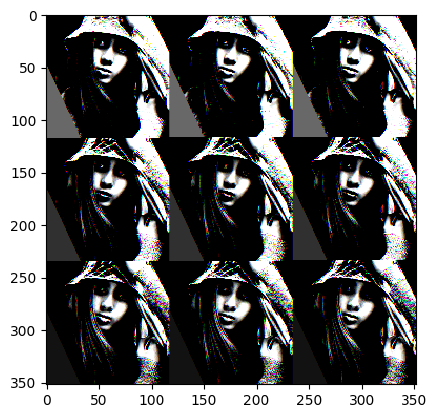

2023-11-15 19:51:34,343 - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


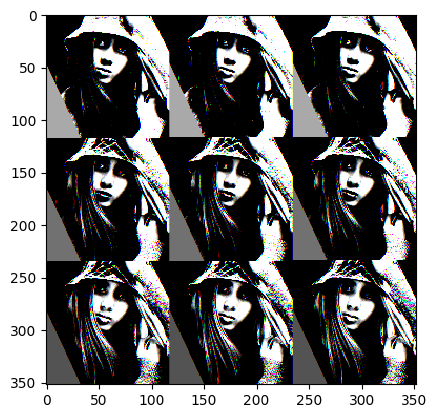

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:425: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_min = np.asscalar(a_min.astype(scaled_dtype))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:426: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_max = np.asscalar(a_max.astype(scaled_dtype))


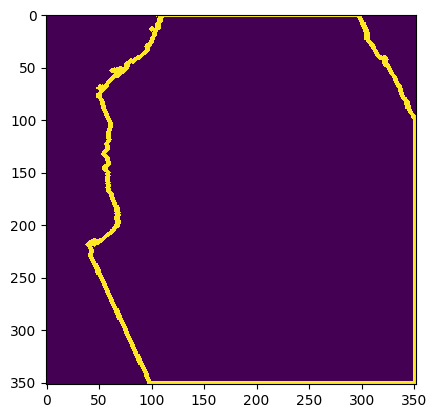

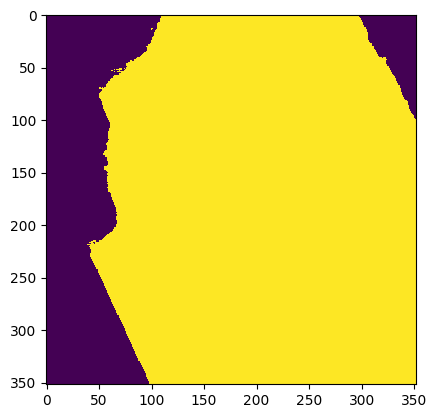

In [ ]:
%cd work/
from data import MyDataset 
train_dataset = MyDataset(exp_args)
# val_dataset = MyDataset(is_model = "")
num = 0
print('=============train dataset=============')
for input_ori, input, output_edge, output_mask in train_dataset:
    #num += 1
    print(input_ori.shape)
    print(input.shape)
    print(output_edge.shape)
    print(output_mask.shape)
    #可视化
    input_ori = input_ori.reshape([input_ori.shape[1],input_ori.shape[2],input_ori.shape[0]])
    plt.imshow(input_ori)
    plt.show()

    input = input.reshape([input.shape[1],input.shape[2],input.shape[0]])
    plt.imshow(input)
    plt.show()

    plt.imshow(output_edge)
    plt.show()

    plt.imshow(output_mask)
    plt.show()

    break
    

In [ ]:

mymodel = MobileNetV2(n_class=2, 
                            useUpsample=exp_args.useUpsample, 
                            useDeconvGroup=exp_args.useDeconvGroup, 
                            addEdge=exp_args.addEdge, 
                            channelRatio=1.0, 
                            minChannel=16, 
                            video=exp_args.video)


W1115 19:51:40.114442  4330 device_context.cc:362] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 12.0, Runtime API Version: 10.1
W1115 19:51:40.119930  4330 device_context.cc:372] device: 0, cuDNN Version: 7.6.


In [ ]:

writer = LogWriter("./log_supervisely")

In [ ]:

def calcIOU(img, mask):
    sum1 = img + mask
    sum1[sum1>0] = 1
    sum2 = img + mask
    sum2[sum2<2] = 0
    sum2[sum2>=2] = 1
    if np.sum(sum1) == 0:
        return 1
    else:
        return 1.0*np.sum(sum2)/np.sum(sum1)

def loss_KL(student_outputs, teacher_outputs, T):
    """
    Code referenced from: 
    https://github.com/peterliht/knowledge-distillation-pytorch/blob/master/model/net.py
    
    Compute the knowledge-distillation (KD) loss given outputs, labels.
    "Hyperparameters": temperature and alpha
    NOTE: the KL Divergence for PyTorch comparing the softmaxs of teacher
    and student expects the input tensor to be log probabilities! See Issue #2
    """
    KD_loss = paddle.nn.KLDivLoss()(F.log_softmax(student_outputs/T, axis=1), 
                             F.softmax(teacher_outputs/T, axis=1)) * T * T
    return KD_loss
#Focalloss
def loss_Focalloss(pred,label,gamma = 2.0):
    N,C,H,W = pred.shape[0],pred.shape[1],pred.shape[2],pred.shape[3]
    pred = pred.reshape([N,C,-1])# N,C,H,W => N,C,H*W
    pred = pred.transpose((0,2,1))# N,C,H*W => N,H*W,C
    pred = pred.reshape([-1,C])# N,H*W,C => N*H*W,C
    label = label.reshape([-1,1])#N,H,W => N*H*W,1
    
    label = paddle.squeeze(label,axis=1)#去除多余维度
    label = paddle.nn.functional.one_hot(label, num_classes=2)
    label = paddle.to_tensor(label,dtype="float32")

    one = paddle.to_tensor([1.], dtype='float32')
    fg_label = paddle.greater_equal(label, one)
    fg_num = paddle.sum(paddle.cast(fg_label, dtype='float32'))
    loss_focal = paddle.nn.functional.sigmoid_focal_loss(pred,label,normalizer=fg_num)
    # pt = paddle.nn.functional.softmax(pred)#带入分类器
    # #a = paddle.to_tensor(1,dtype="int64")
    # label_one_hot = paddle.nn.functional.one_hot(label, num_classes=2)
    # pt = paddle.multiply(pt,label_one_hot)
    # #pt = pt.gather(a,label)#将是1的标签提取出来
    # # min_pro = paddle.to_tensor(0.1,dtype="float64")
    # # pt = paddle.maximum(pt,min_pro)#当预测值很小时候，给他个定值
    # loss_focal = -1 * paddle.log(pt) * ((1-pt)**gamma
    return loss_focal

In [ ]:
def test(epoch):
    #验证集
    exp_args.istrain = False
    
    val_dataset = MyDataset(exp_args)
    val_loader = paddle.io.DataLoader(val_dataset, places=paddle.CUDAPlace(0), batch_size=1)#bs 应当为1，表示一张张预测

    iou = 0
    #定义损失函数
    loss_Softmax = paddle.nn.CrossEntropyLoss(reduction='mean', axis=1,ignore_index=255)
    mymodel.eval()

    for batch_id, (input_ori, input, edge, mask) in enumerate(val_loader):  
        input_ori_var = paddle.to_tensor(input_ori)
        input_var = paddle.to_tensor(input)
        edge_var = paddle.to_tensor(edge)
        mask_var = paddle.to_tensor(mask)
        
        if exp_args.addEdge == True:
            output_mask, output_edge = mymodel(input_var)
            loss_mask = loss_Softmax(output_mask, mask_var)
            
            # loss_edge = loss_l2(output_edge, edge_var) * exp_args.edgeRatio
            loss_edge = loss_Focalloss(output_edge, edge_var) * exp_args.edgeRatio
            loss = loss_mask + loss_edge
            
            if exp_args.stability == True:
                output_mask_ori, output_edge_ori = mymodel(input_ori_var)
                loss_mask_ori = loss_Softmax(output_mask_ori, mask_var)
                # loss_edge_ori = loss_l2(output_edge_ori, edge_var) * exp_args.edgeRatio
                loss_edge_ori = loss_Focalloss(output_edge_ori, edge_var) * exp_args.edgeRatio

                if exp_args.use_kl == True:
                    # consistency constraint loss: L2 distance 
                    loss_stability_mask = loss_KL(output_mask, 
                                                    paddle.to_tensor(output_mask_ori),
                                                    exp_args.temperature) * exp_args.alpha
                loss = loss_mask + loss_mask_ori + loss_stability_mask + loss_edge
        else:
            output_mask = mymodel(input_var)
            loss_mask = loss_Softmax(output_mask, mask_var)
            loss = loss_mask

        pred = output_mask

        prob = F.softmax(output_mask,axis=1)[0,1,:,:]
        pred = prob.numpy()

        pred[pred>0.5] = 1
        pred[pred<=0.5] = 0
        iou += calcIOU(pred, mask_var[0].numpy())
    miou = iou/len(val_loader)
    myfile = open("/home/aistudio/work/supervisely_log.txt","a+")
    myfile.write(str(epoch)+" "+str(miou)+"\n")
    
    print("miou:",miou)
    return miou

In [9]:
def train():
    exp_args.istrain = True

    
    epochs = 2000
    batch_size = 64
    weight_decay_L2 = 5e-4

    #lr = paddle.optimizer.lr.PolynomialDecay(learning_rate=0.0001, decay_steps=1,end_lr=0.000001 , verbose=True)
    #lr = paddle.optimizer.lr.PiecewiseDecay(boundaries=[15, 25], values=[0.001, 0.0001, 0.00001], verbose=True)
    lr = paddle.optimizer.lr.LambdaDecay(learning_rate=0.001, lr_lambda=lambda x:0.95**x, verbose=True)#,last_epoch = 17)

    train_dataset = MyDataset(exp_args)
    train_loder =  paddle.io.DataLoader(train_dataset, places=paddle.CUDAPlace(0) ,batch_size=batch_size, shuffle=True)


    opt = paddle.optimizer.Adam(learning_rate=lr, parameters = mymodel.parameters(),weight_decay=weight_decay_L2)


    # mymodel_state_dict = paddle.load("/home/aistudio/work/save_model/350_0.9474887934352134/350.pdparams")
    # mymodel.set_state_dict(mymodel_state_dict)
    max_miou = 0
    steps = 0

    loss_Softmax = paddle.nn.CrossEntropyLoss(reduction='mean', axis=1,ignore_index=255)
    for epoch in range(1,int(epochs)):
        loss_sum = 0
        mymodel.train()
        for batch_id, (input_ori, input, edge, mask) in enumerate(train_loder()):
            input_ori_var = paddle.to_tensor(input_ori)
            input_var = paddle.to_tensor(input)
            edge_var = paddle.to_tensor(edge)
            mask_var = paddle.to_tensor(mask)
            
            if exp_args.addEdge == True:
                output_mask, output_edge = mymodel(input_var)
                loss_mask = loss_Softmax(output_mask, mask_var)
                
                # loss_edge = loss_l2(output_edge, edge_var) * exp_args.edgeRatio
                loss_edge = loss_Focalloss(output_edge, edge_var) * exp_args.edgeRatio
                
                # total loss
                loss = loss_mask + loss_edge
                
                if exp_args.stability == True:
                    output_mask_ori, output_edge_ori = mymodel(input_ori_var)
                    loss_mask_ori = loss_Softmax(output_mask_ori, mask_var)
                    
                    # loss_edge_ori = loss_l2(output_edge_ori, edge_var) * exp_args.edgeRatio
                    loss_edge_ori = loss_Focalloss(output_edge_ori, edge_var) * exp_args.edgeRatio
                    
                    # in our experiments, kl loss is better than l2 loss
                    if exp_args.use_kl == True:
                        # consistency constraint loss: KL distance (better than L2 distance)
                        loss_stability_mask = loss_KL(output_mask, 
                                                        paddle.to_tensor(output_mask_ori), 
                                                        exp_args.temperature) * exp_args.alpha
                        # loss_stability_edge = loss_KL(output_edge, 
                        #                                 paddle.to_tensor(output_edge_ori, requires_grad = False), 
                        #                                 exp_args.temperature) * exp_args.alpha * exp_args.edgeRatio
                    
                    # total loss
                    # loss = loss_mask + loss_mask_ori + loss_edge + loss_edge_ori + loss_stability_mask + loss_stability_edge
                    loss = loss_mask + loss_mask_ori + loss_stability_mask + loss_edge
            else:
                output_mask = mymodel(input_var)
                loss_mask = loss_Softmax(output_mask, mask_var)
                
                # total loss: only include mask loss
                loss = loss_mask
                
                if exp_args.stability == True:
                    output_mask_ori = mymodel(input_ori_var)
                    loss_mask_ori = loss_Softmax(output_mask_ori, mask_var)
                    losses_mask_ori.update(loss_mask_ori.data[0], input.size(0))
                    if exp_args.use_kl == False:
                        # consistency constraint loss: KL distance (better than L2 distance)
                        loss_stability_mask = loss_KL(output_mask, 
                                                        paddle.to_tensor(output_mask_ori), 
                                                        exp_args.temperature) * exp_args.alpha
                    # total loss
                    loss = loss_mask + loss_mask_ori + loss_stability_mask

            
            if steps % 10 is 0:
                #添加loss
                writer.add_scalar(tag="train/loss", step=steps, value=float(loss.numpy()))
                
                # #记录每一个批次第一张图片
                # img = np.reshape(np.array(data[0][0].numpy()), [224, 224, 3])
                # writer.add_image(tag="train/input", step=steps, img=img)
            
            loss_sum += loss.numpy()
    
            loss.backward()
            opt.step()

            opt.clear_grad()
            steps += 1
        
        print("第{}轮，loss：{}".format(epoch,loss_sum/(batch_id+1)))
        miou = test(epoch)
        if max_miou < miou:
            max_miou = miou
            # max_miou_file = open("/home/aistudio/work/max_miou_log_supervisely.txt","w")
            # max_miou_file.write(str(epoch)+" "+str(max_miou)+"\n")

            if not os.path.exists(os.path.join("/home/aistudio/work/save_model2")):
                os.mkdir(os.path.join("/home/aistudio/work/save_model2"))
            if not os.path.exists(os.path.join("/home/aistudio/work/save_model2", str(epoch))):
                os.mkdir(os.path.join("/home/aistudio/work/save_model2", str(epoch)))
            paddle.save(mymodel.state_dict(), os.path.join("/home/aistudio/work/save_model2", str(epoch), str(epoch) + ".pdparams"))
            paddle.save(opt.state_dict(), os.path.join("/home/aistudio/work/save_model2", str(epoch), str(epoch) + ".pdopt"))
        if (epoch) % 20 == 0:
            lr.step()
        

train()

Epoch 0: LambdaDecay set learning rate to 0.001.


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dataloader/dataloader_iter.py:89: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(slot[0], (np.ndarray, np.bool, numbers.Number)):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:648: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/tensor/creation.py:143: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` 

第1轮，loss：[1.1641701]
miou: 0.6417846901483708
第2轮，loss：[0.83779484]
miou: 0.6902206744577236


KeyboardInterrupt: 

In [ ]:

epochs = 30
lr = paddle.optimizer.lr.PiecewiseDecay(boundaries=[15, 25], values=[0.001, 0.0001, 0.00001], verbose=True)
weight_decay_L2 = 5e-4

exp_args.istrain = False
val_dataset = MyDataset(exp_args)
val_loader = paddle.io.DataLoader(val_dataset, places=paddle.CUDAPlace(0), batch_size=1)#bs 应当为1，表示一张张预测
#定义优化器
opt = paddle.optimizer.Adam(learning_rate=0.01, parameters = mymodel.parameters(),weight_decay=weight_decay_L2)
mymodel_state_dict = paddle.load("/home/aistudio/work/supervisely_save_model/1271.pdparams")
mymodel.set_state_dict(mymodel_state_dict)
# opt_state_dict = paddle.load("/home/aistudio/work/save_model/1336/1336.pdopt")
# opt.set_state_dict(opt_state_dict)

iou = 0
#定义损失函数
loss_Softmax = paddle.nn.CrossEntropyLoss(reduction='mean', axis=1,ignore_index=255)
mymodel.eval()

for batch_id, (input_ori, input, edge, mask) in enumerate(val_loader):  
    input_ori_var = paddle.to_tensor(input_ori)
    input_var = paddle.to_tensor(input)
    edge_var = paddle.to_tensor(edge)
    mask_var = paddle.to_tensor(mask)
    
    if exp_args.addEdge == True:
        output_mask, output_edge = mymodel(input_var)
        loss_mask = loss_Softmax(output_mask, mask_var)
        
        # loss_edge = loss_l2(output_edge, edge_var) * exp_args.edgeRatio
        loss_edge = loss_Focalloss(output_edge, edge_var) * exp_args.edgeRatio
        loss = loss_mask + loss_edge
        
        if exp_args.stability == True:
            output_mask_ori, output_edge_ori = mymodel(input_ori_var)
            loss_mask_ori = loss_Softmax(output_mask_ori, mask_var)
            # loss_edge_ori = loss_l2(output_edge_ori, edge_var) * exp_args.edgeRatio
            loss_edge_ori = loss_Focalloss(output_edge_ori, edge_var) * exp_args.edgeRatio

            if exp_args.use_kl == True:
                # consistency constraint loss: L2 distance 
                loss_stability_mask = loss_KL(output_mask, 
                                                paddle.to_tensor(output_mask_ori),
                                                exp_args.temperature) * exp_args.alpha
                # loss_stability_edge = loss_KL(output_edge, 
                #                                 paddle.to_tensor(output_edge_ori, 
                #                                         requires_grad = False)) * exp_args.alpha * exp_args.edgeRatio
                
            
            # total loss
            # loss = loss_mask + loss_mask_ori + loss_edge + loss_edge_ori + loss_stability_mask + loss_stability_edge
            loss = loss_mask + loss_mask_ori + loss_stability_mask + loss_edge
    else:
        output_mask = mymodel(input_var)
        loss_mask = loss_Softmax(output_mask, mask_var)
        loss = loss_mask

    pred = output_mask

    prob = F.softmax(output_mask,axis=1)[0,1,:,:]
    pred = prob.numpy()
    pred[pred>0.5] = 1
    pred[pred<=0.5] = 0
    iou += calcIOU(pred, mask_var[0].numpy())
print(iou/len(val_loader))